![ACM SIGCHI Summer School on Computational Interaction](imgs/header.png)

# <font face="gotham" color="Brown"> Image based VA_RecSys with ResNet </font>




## Table of Contents

1. [Improt Deependencies](#dep)
2. [Load dataset](#loaddata)
3. [Preprocessing](#preproc)
4. [Visual Feature extraction via Transfer Learning](#doc)<br>
5. [Top-K Recommendation](#topn)
6. [Conclusion](#exp)

# <font face="gotham" color="darkred"> The typical RecSys Pipeline  </font>

![The RecSys pipline](imgs/recsys.png)

## 1. Improt Deependencies 

<a id="dep"></a>

In [10]:
import os
import re
import sys
import pandas as pd
from tqdm import tqdm
import numpy as np
from PIL import Image
import pickle
import torch
import matplotlib.pyplot as plt
from torchmetrics.functional import pairwise_cosine_similarity
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50

## 2. Load dataset

<a id="loaddata"></a>
The dataset used in this tutorial contains >= 2,300 paintings collections from the National Gallery, London, dating from the mid-13th century to 1900.

![Sample painting](imgs/sample.png)

In [11]:
df = pd.read_csv('resources/datasets/ng-dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.rename(columns={'merged_description': 'enhanced'}, inplace=True)

In [12]:
df.head()

,painting_id,title,artist,date,room,size_format,size_class,description,technique,image,enhanced
0,000-00A8-0000,A Cup of Water and a Rose,Francisco de ZurbarÃÂ¡n,17th_century,006-002N-0000,Landscape,Very Small,<p>Although ZurbarÃÂ¡n frequently included st...,oil painting,https://media.ng-london.org.uk/iiif/009-00YS-0...,<p>Although ZurbarÃÂ¡n frequently included st...
1,000-00S0-0000,Man on a Ladder,Luca Signorelli,16th_century,006-0002-0000,Portrait,Medium,<p>Signorelli is celebrated for his mastery of...,oil painting,https://media.ng-london.org.uk/iiif/009-00UA-0...,<p>Signorelli is celebrated for his mastery of...
2,000-0162-0000,The Boulevard Montmartre at Night,Camille Pissarro,19th_century,006-000L-0000,Landscape,Small,<p>Towards the end of his life Pissarro increa...,oil painting,https://media.ng-london.org.uk/iiif/009-018T-0...,<p>Towards the end of his life Pissarro increa...
3,000-0163-0000,"View of the Westerkerk, Amsterdam",Jan van der Heyden,17th_century,006-000B-0000,Landscape,Medium,<p>This painting is unusually large. It was co...,oil painting,https://media.ng-london.org.uk/iiif/009-01OT-0...,<p>This painting is unusually large. It was co...
4,000-0164-0000,The Museum at Le Havre,Claude Monet,19th_century,006-000T-0000,Landscape,Medium,<p>This is an important work which dates from ...,oil painting,https://media.ng-london.org.uk/iiif/009-01WV-0...,<p>This is an important work which dates from ...


## 4. Visual Feature extraction via 

<a id="doc"></a>

![Transfer Learning](imgs/transfer.png)





![resnet](imgs/resnet.png)

In [13]:
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x).reshape(-1)
    return features

def extract_features_from_directory(dir_path, model):
    features_list = dict()
    painting_ids = []  # Initialize an empty list for storing file names
    files = os.listdir(dir_path)
    for file in tqdm(files):
        file_name = file.replace('.jpg', '')
        painting_ids.append(file_name)  # Append file name to the list
        features_list[file_name] = extract_features((dir_path + file), model)
    return features_list, painting_ids


# Load the model to be used as feature extractor
model = ResNet50(weights='imagenet', include_top=False)

# Extract features
features_list, painting_ids = extract_features_from_directory(dir_path='resources/datasets/ng_images/', model=model)

# Generate a new pickle file with the ResNEt features
DATASET_ResNet_FILE = 'Models/paintings_resnet_features.pickle'

# Dump both lists into a dictionary within a .pickle file.
file = open(DATASET_ResNet_FILE, 'wb')
pickle_rick = {"painting_ids": painting_ids, "resnet_features": features_list}
pickle.dump(pickle_rick, file)
file.close()

100%|███████████████████████████████████████| 2325/2325 [02:16<00:00, 17.09it/s]


## 5. Top-K Recommendation
<a id="topn"></a>

In [24]:
class ResNetEngine():
    def __init__(self):
        # self.painting_ids = None
        # self.resnet_features = None
        self.load_data()

    def unpack_prefs(self, preferences):
        painting_list = []
        weights = []
        for painting, rating in preferences.items():
            painting_list.append(painting)
            weights.append(rating)
        xmin = min(weights)
        xmax = max(weights)
        for i, x in enumerate(weights):
            weights[i] = (x - xmin) / (xmax - xmin + sys.float_info.epsilon)

        return painting_list, weights
    
    def load_data(self):
        # Load dataset.
        dataset = pickle.load(
            open("Models/paintings_resnet_features.pickle", "rb")
        )

        # Pre-process dataset to remove missing paintings.
        painting_ids = []
        resnet_features = []
        image_files_names = os.listdir("resources/datasets/ng_images/")
        painting_ids_dict = dict.fromkeys(dataset["painting_ids"], "YES")

                
        for i in range(0, len(image_files_names)):
            painting_name = re.sub(".jpg", "", image_files_names[i])
            if painting_name in painting_ids_dict.keys():
                painting_ids.append(painting_name)
                resnet_features_dict = dataset["resnet_features"]
                resnet_features.append(resnet_features_dict[painting_name])

        self.painting_ids = painting_ids
        self.resnet_features = resnet_features

    def get_distances(self, selected_image_names):
        """
        Input:
            -> selected_image_names: list with strings of names of the images to analyse.
        Output:
            -> distances: numpy with cosine distance between each image in selected_image_names and resnet_features.
        """
        selected = []
        top_sim_images = []

        # Get the features of the selected images using the painting_ids list.
        for i in range(len(selected_image_names)):
            feat_idx = self.painting_ids.index(selected_image_names[i])
            selected.append(self.resnet_features[feat_idx])
        selected = np.asarray(selected)
        resnet_features = np.asarray(self.resnet_features)

        # Calculate cosine distance with torch.
        selected = torch.from_numpy(selected)
        resnet_features = torch.from_numpy(resnet_features)
        cosine_distances = pairwise_cosine_similarity(selected, resnet_features)
        cosine_distances = cosine_distances.numpy()
        return cosine_distances

    def get_top_similars(self, distances, n):
        """
        Input:
            -> distances: numpy of distances from some paintings to the rest of the original dataset.
            -> painting_ids: list of names of the images.
            -> n: number of top-N most similar images to consider.
        Output:
            -> top_sim_images: list with the names of the top-N most similar images.
        """
        top_sim_images = []
        for i in range(distances.shape[0]):
            top_distances = np.argsort(distances[i, :]).reshape(-1)[:n]
            nearest_ids = [self.painting_ids[idx] for idx in top_distances]
            top_sim_images.append(nearest_ids)
        return top_sim_images, top_distances

    def get_weighted_distances(self, distances, weights):
        """
        Input:
            -> distances: numpy of distances from some paintings to the rest of the original dataset.
            -> wights: a list of weights given to each painting.
        Output:
            -> weighted_distances: numpy with weighted avg distances of shape (1, distances.shape[1]).
            -> confidences: numpy with the inverse of weighted_distances an the same shape.
        """
        assert (
            len(weights) == distances.shape[0]
        )  # Assert if num weights == num images used to calculate distance.
        weights = np.asarray(weights).reshape(-1, 1)
        N = distances.shape[0]
        weighted_distances = np.sum(np.multiply(weights, distances), axis=0) / N
        weighted_distances = np.reshape(weighted_distances, (1, -1))
        confidences = 1 - weighted_distances
        return weighted_distances, confidences

    def retrieval(self, preferences, n=3):
        """Recommand paintings for a user based on a list of items that were liked
        Input:
                painting_list: list of paintings index liked by a user
                weights: user ratings
                n: number of recommendation wanted
        Output:
                a list of indexes for recommended paintings
        """
        painting_list, weights = self.unpack_prefs(preferences)

        # Apply function and get distances and top-N most similar images.
        distances = self.get_distances(painting_list)

        # Apply the weighting mechanism.
        weighted_distances, weighted_confidences = self.get_weighted_distances(
            distances, weights
        )
        top_n_pids, top_distances = self.get_top_similars(weighted_distances, n)
        top_n_pids = [item for sublist in top_n_pids for item in sublist]
        # weighted_confidences = weighted_confidences.reshape(-1)
        # scores = np.sort(weighted_confidences[:n])[::-1]
        return list(top_n_pids)

In [25]:
#Plot paintings
dir_path='resources/datasets/ng_images/'        
def print_images(dir_path, selected_images_keys_list):
    fig, axes = plt.subplots(1, len(selected_images_keys_list), figsize=(15, 5))
    
    for i, image_key in enumerate(selected_images_keys_list):
        img_path = os.path.join(dir_path, f"{image_key}.jpg")
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(image_key)
        axes[i].axis('off')
    
    plt.tight_layout()
    #display(fig)

### Simulate User preferences

In [26]:
preferences = {
        "000-03KA-0000": 1,
        "000-03LH-0000": 1,
        "000-03LI-0000": 1,
        "000-02ND-0000": 1,
        "000-03UX-0000": 1,
        "000-019R-0000": 5,
        "000-03UY-0000": 1,
        "000-019X-0000": 1,
        "000-03V4-0000": 5,
    }

### Retrieve top-K  Recommendations 

In [27]:
eng = ResNetEngine()
Recommendations = eng.retrieval(preferences, n=9)

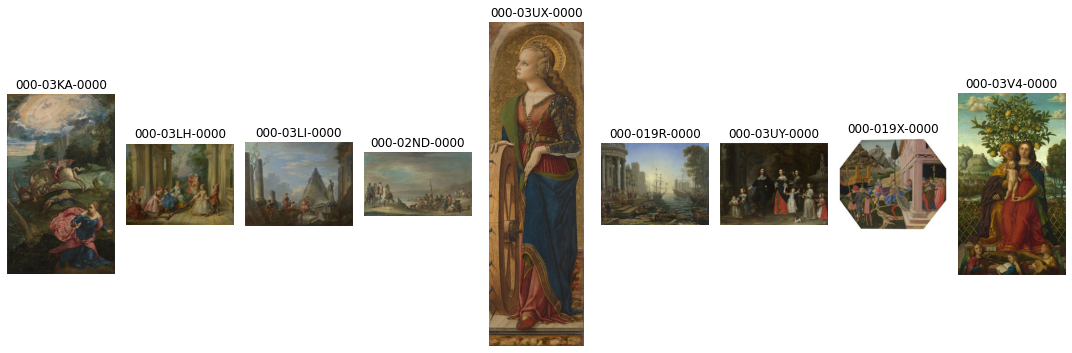

In [28]:
#plot user preferences
print_images(dir_path, preferences.keys())

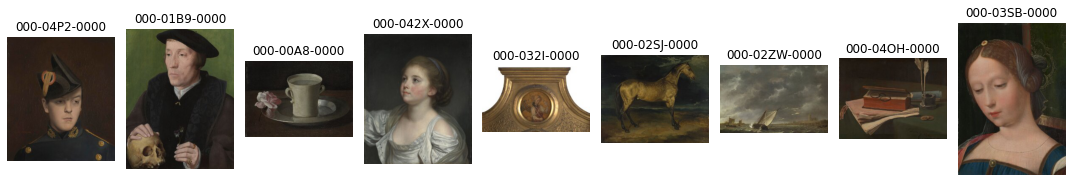

In [29]:
#plot Recommendations
print_images(dir_path, Recommendations)

## 🏁 6. Conclusion

<a id="con"></a>

Now, you know:

1. How to extract Visual features by transfer learning using pre-trained vision Models such as ResNet50
2. How to leverage the extracted features for a Recommendation task

The resourses used in this tutorial are partially taken from our [CHI2023 paper: The Elements of Visual Art Recommendation: Learning Latent Semantic Representations of Paintings](https://dl.acm.org/doi/abs/10.1145/3544548.3581477)

![VA_RecSys](imgs/VA_RecSys.png)



